In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR

In [2]:
origin_raw_data_dir = 'C:\\Users\\a1882\\Desktop\\EEG\\normal\\data\\128_s100'
model_save ='C:\\Users\\a1882\\Desktop\\EEG\\normal\\model'
pic_dir = 'C:\\Users\\a1882\\Desktop\\EEG\\normal\\pic'

In [3]:
class EEG_Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = origin_raw_data_dir
        self.file_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        data = pd.read_csv(file_path, header=None)
        data = data.values
        data = torch.from_numpy(data)
        label_map = {'lefthand': 0, 'read': 1, 'rest': 2, 'walkbase': 3, 'walkl': 4 ,'walkfocus': 5}
        data_label = label_map[file_name.split('_')[0]]
        return data, data_label

In [4]:
dataset = EEG_Dataset(origin_raw_data_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [18]:
class EEGNet_CAM(nn.Module):
    def __init__(self, num_classes=6):
        super(EEGNet_CAM, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout2 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 1), stride=(2, 1))
        self.bn3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout3 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.conv3_cam = None

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        # print('x:', x.shape)
        x = self.conv1(x)
        # print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # print('pool1:', x.shape)
        x = self.dropout1(x)
        x = self.conv2(x)
        # print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # print('pool2:', x.shape)
        x = self.dropout2(x)
        x = self.conv3(x)
        # print('conv3:',x.shape)
        self.conv3_cam = x.clone()  # save the activation maps for CAM
        x = self.bn3(x)
        # x = torch.relu(x)
        x = self.pool3(x)
        # print('pool3:',x.shape)
        x = x.view(x.size(0), -1)
        # print('flatten:', x.shape)
        x = self.fc1(x)
        # print('fc1:', x.shape)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        # print('fc2:', x.shape)
        return x

    def get_cam(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self

In [17]:
X = torch.randn(size=( 1, 32, 128), dtype=torch.float32)
model = EEGNet_CAM()
output = model(X)
print(output.shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
learning_rate = 0.001
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            global train_loss
            train_loss.append(loss)



def test(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    global valid_loss
    valid_loss.append(test_loss)
    global accuracy
    accuracy.append(correct)

In [10]:
#torch.cuda.empty_cache()
# model = model = EEG_LSTM(input_size=31000, hidden_size=128, num_layers=2,num_classes=train_class_number).to(device)
#model = model.cuda()
train_loss = []
valid_loss = []
accuracy = []
for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    model.train(True)
    train(train_loader, model, loss_fn, optimizer)

    model.train(False)
    test(test_loader, model, loss_fn)

    if t > num_epochs-5:
        torch.save(model.state_dict(), os.path.join(model_save,'CAM_retrain'+str(t)+'.pt'))

print("Done!")

Epoch 1
-------------------------------
loss: 1.832872  [    0/ 3788]
Test Error:
 Accuracy: 48.4%, Avg loss: 1.468137 

Epoch 2
-------------------------------
loss: 1.102645  [    0/ 3788]
Test Error:
 Accuracy: 65.0%, Avg loss: 1.117153 

Epoch 3
-------------------------------
loss: 0.785547  [    0/ 3788]
Test Error:
 Accuracy: 70.0%, Avg loss: 0.882988 

Epoch 4
-------------------------------
loss: 0.632607  [    0/ 3788]
Test Error:
 Accuracy: 72.4%, Avg loss: 0.721445 

Epoch 5
-------------------------------
loss: 0.509811  [    0/ 3788]
Test Error:
 Accuracy: 74.0%, Avg loss: 0.647056 

Epoch 6
-------------------------------
loss: 0.463576  [    0/ 3788]
Test Error:
 Accuracy: 77.4%, Avg loss: 0.584014 

Epoch 7
-------------------------------
loss: 0.424839  [    0/ 3788]
Test Error:
 Accuracy: 79.5%, Avg loss: 0.533163 

Epoch 8
-------------------------------
loss: 0.358123  [    0/ 3788]
Test Error:
 Accuracy: 83.0%, Avg loss: 0.430946 

Epoch 9
------------------------

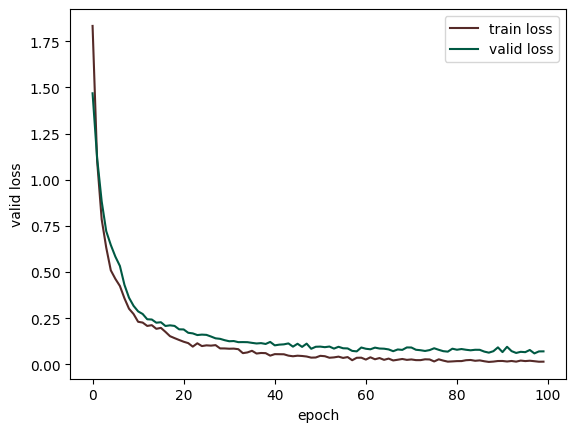

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
hex_d1 = '#552a28'
hex_d2 = '#005943'

plt.figure()
plt.plot(train_loss, hex_d1, label='train loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.plot(valid_loss, hex_d2, label='valid loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(os.path.join(pic_dir, 'CAM_retrain_loss.png'))
plt.show()

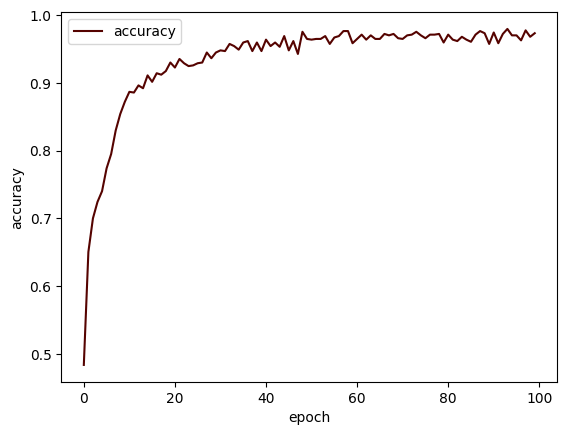

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(accuracy, color = '#550300', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(pic_dir,'CAM_retrain_accuracy.png'))
plt.show()

In [15]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
model.eval()
# Load the EEGNet model with CAM
model = EEGNet_CAM(num_classes=6)

# Load the input sample
data = pd.read_csv("C:\\Users\\a1882\\Desktop\\EEG\\normal\\data\\128_s100\\lefthand_zyy_04_epocflex_2023_window_2.csv", header=None)
data = data.values
data = torch.from_numpy(data)
data = data.unsqueeze(0)
input_sample = data  # Replace with the path to your input sample
input_tensor = torch.Tensor(input_sample)

# Get the model's predicted class
model.eval()
with torch.no_grad():
    output = model(input_tensor.float())
predicted_class = torch.argmax(output).item()

# Generate the CAM
cam = model.get_cam(input_tensor, predicted_class, layer_name="conv1")
cam2 = model.generate_cam(input_tensor, predicted_class, layer_name="conv2")

# Convert the CAMs to PIL images and visualize them
cam_image = Image.fromarray(cam)
cam2_image = Image.fromarray(cam2)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cam_image)
ax1.set_title("CAM for Conv1")
ax2.imshow(cam2_image)
ax2.set_title("CAM for Conv2")
plt.show()

TypeError: EEGNet_CAM.get_cam() got an unexpected keyword argument 'layer_name'